<a href="https://colab.research.google.com/github/AashiDutt/ADVANCED-DEPLOYMENT-SCENARIOS-WITH-TENSORFLOW/blob/master/MNIST_WITH_TFSERVING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

In [2]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.2.0-rc3


In [0]:
# importing MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
# EXERCISE: Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images /255.0
test_images = test_images/ 255.0

In [0]:
# EXERCISE: Reshape the arrays below.
train_images = train_images.reshape(train_images.shape[0], 28,28, 1)
test_images = test_images.reshape(test_images.shape[0], 28,28, 1)

In [6]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


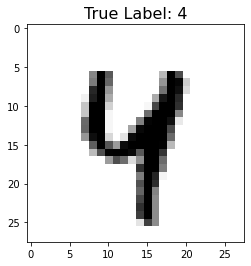

In [7]:
# sample image
idx = 42

plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

In [8]:
#  Create a model.
model = tf.keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Configure the model for training.
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 5

# Train the model.
history = model.fit(train_images, train_labels, epochs=epochs)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3620 - accuracy: 0.8988
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1777 - accuracy: 0.9496
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1303 - accuracy: 0.9626
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1088 - accuracy: 0.9687
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0974 - accuracy: 0.9716


In [10]:
# Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels,verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

loss: 0.0948
accuracy: 0.971


In [11]:
# Save the Model

MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 84
drwxr-xr-x 2 root root  4096 Apr 28 05:54 assets
-rw-r--r-- 1 root root 76012 Apr 28 05:54 saved_model.pb
drwxr-xr-x 2 root root  4096 Apr 28 05:54 variables


In [12]:
# Examine saved model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0428 05:54:58.755362 140445157062528 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pytho

In [13]:
# Add TensorFlow Serving Distribution URI as a Package Source

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   151k      0 --:--:-- --:--:-- --:--:--  151k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.

In [14]:
# install tensorflow serving
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.1.0).
0 upgraded, 0 newly installed, 0 to remove and 97 not upgraded.


Run the TensorFlow Model Server

You will now launch the TensorFlow model server with a bash script. In the cell below use the following parameters when running the TensorFlow model server:

rest_api_port: Use port 8501 for your requests.
model_name: Use digits_model as your model name.
model_base_path: Use the environment variable MODEL_DIR defined below as the base path to the saved model.

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [21]:
# EXERCISE: Fill in the missing code below.
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [22]:
!tail server.log

2020-04-28 05:56:10.461700: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-28 05:56:10.477240: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:203] Restoring SavedModel bundle.
2020-04-28 05:56:10.496622: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /tmp/1
2020-04-28 05:56:10.500865: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 40595 microseconds.
2020-04-28 05:56:10.501406: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-04-28 05:56:10.501519: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: digits_model version: 1}
2020-04-28 05:56:10.50263

In [23]:
# Create JSON Object with Test Images

data =json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


Make Inference Request

In the cell below, send a predict request as a POST to the server's REST endpoint, and pass it your test data. You should ask the server to give you the latest version of your model.

In [0]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']

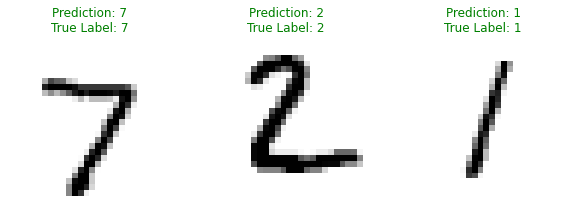

In [25]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()